# <center> Collaborative Filtering Model Based Recommendation System 

### Import necessary libraries

In [1]:
# pandas and numpy
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

# other
import string
import math
import random
import missingno as msno

# data viz
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

#sklearn
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from joblib import dump
from joblib import load


### Read in the data

Here I am reading in the different data files and merging the appropriately. 

In [2]:
songs_df = pd.read_csv("songs.csv")
songs_extra_df = pd.read_csv("song_extra_info.csv")
members_df = pd.read_csv("members.csv")
train_df = pd.read_csv("train.csv", nrows = 100000)
train_songs = pd.merge(train_df, songs_df, on='song_id', how='left')
t_s_se = pd.merge(train_songs, songs_extra_df, on='song_id', how='left')
songs = pd.merge(t_s_se, members_df, on='msno', how='left')
del songs_df, songs_extra_df, members_df, train_df, train_songs, t_s_se
songs.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0,Good Grief,GBUM71602854,1,0,NaN,7,20120102,20171005
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,1259,Various Artists,NaN,NaN,52.0,Lords of Cardboard,US3C69910183,13,24,female,9,20110525,20170911
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,NaN,52.0,Hip Hop Is Dead(Album Version (Edited)),USUM70618761,13,24,female,9,20110525,20170911
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512.0,1019,Soundway,Kwadwo Donkoh,NaN,-1.0,Disco Africa,GBUQH1000063,13,24,female,9,20110525,20170911
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,NaN,52.0,Sleep Without You,QM3E21606003,1,0,NaN,7,20120102,20171005


In [3]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   msno                    100000 non-null  object 
 1   song_id                 100000 non-null  object 
 2   source_system_tab       99697 non-null   object 
 3   source_screen_name      95727 non-null   object 
 4   source_type             99805 non-null   object 
 5   target                  100000 non-null  int64  
 6   song_length             99996 non-null   float64
 7   genre_ids               98498 non-null   object 
 8   artist_name             99996 non-null   object 
 9   composer                78528 non-null   object 
 10  lyricist                59309 non-null   object 
 11  language                99996 non-null   float64
 12  name                    99991 non-null   object 
 13  isrc                    91475 non-null   object 
 14  city                 

### Managing the missing values

I'm identifying all of the places where data is missing.

<AxesSubplot:>

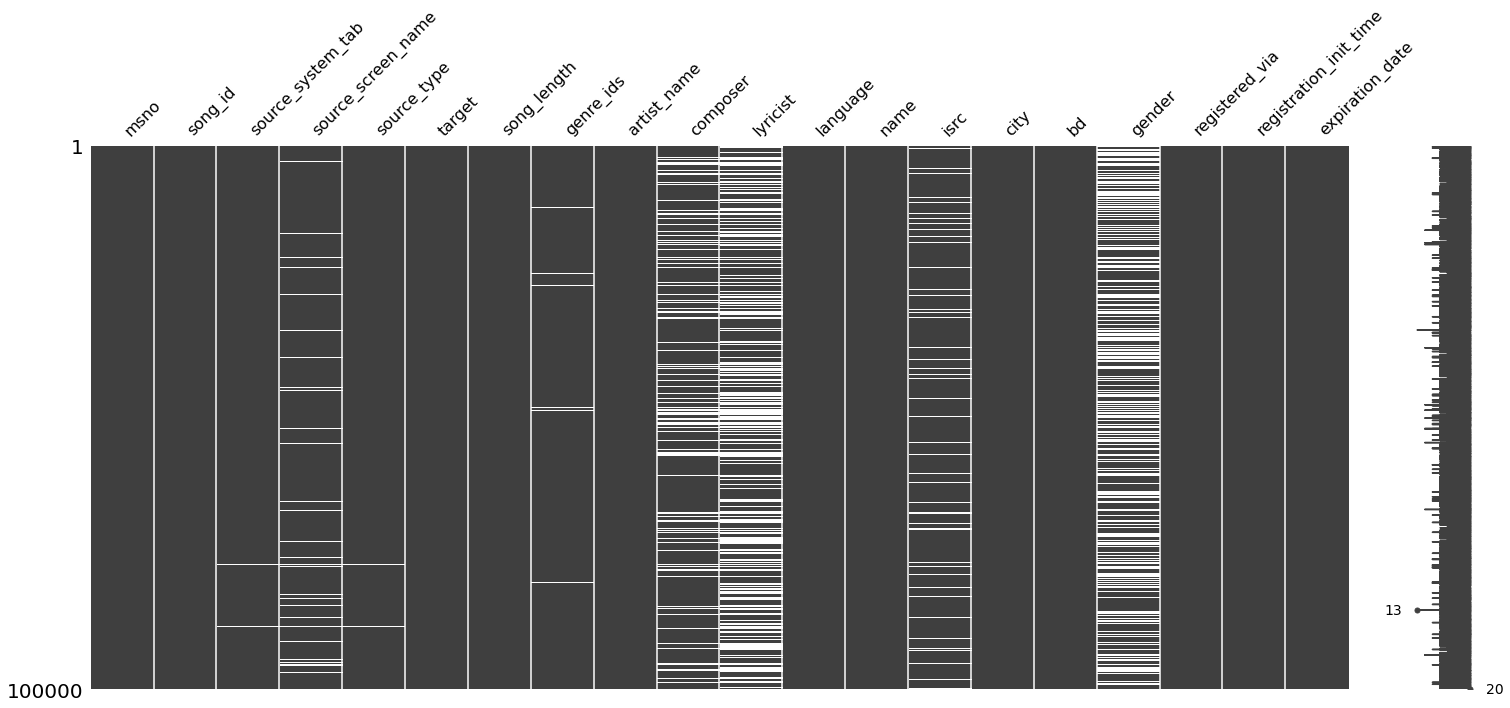

In [4]:
msno.matrix(songs)

Here, I'm finding all the Nans in the object columns and filling them with unknown, followed by the remaining Nans in the numeric columns, which I'm filling with 0.

In [5]:
for i in songs.select_dtypes(include=['object']).columns:
    songs[i][songs[i].isnull()] = 'unknown'
songs = songs.fillna(value=0)

### Obtaining new features

Here I am extracting some date features. 

In [6]:
# registration_init_time
songs.registration_init_time = pd.to_datetime(songs.registration_init_time, format='%Y%m%d', errors='ignore')
songs['registration_init_time_year'] = songs['registration_init_time'].dt.year
songs['registration_init_time_month'] = songs['registration_init_time'].dt.month
songs['registration_init_time_day'] = songs['registration_init_time'].dt.day

# expiration_date
songs.expiration_date = pd.to_datetime(songs.expiration_date,  format='%Y%m%d', errors='ignore')
songs['expiration_date_year'] = songs['expiration_date'].dt.year
songs['expiration_date_month'] = songs['expiration_date'].dt.month
songs['expiration_date_day'] = songs['expiration_date'].dt.day

In [7]:
songs.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,359,Bastille,Dan Smith| Mark Crew,unknown,52.0,Good Grief,GBUM71602854,1,0,unknown,7,2012-01-02,2017-10-05,2012,1,2,2017,10,5
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,1259,Various Artists,unknown,unknown,52.0,Lords of Cardboard,US3C69910183,13,24,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,unknown,52.0,Hip Hop Is Dead(Album Version (Edited)),USUM70618761,13,24,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512.0,1019,Soundway,Kwadwo Donkoh,unknown,-1.0,Disco Africa,GBUQH1000063,13,24,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,unknown,52.0,Sleep Without You,QM3E21606003,1,0,unknown,7,2012-01-02,2017-10-05,2012,1,2,2017,10,5


Now I am going to encode the categorical columns so that I can model the data correctly. 

In [8]:
label_encoder = LabelEncoder()
one_hot = OneHotEncoder()

for i in songs.columns :
    songs[i] = label_encoder.fit_transform(songs[i])

In [9]:
songs

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,1647,6022,1,6,5,1,3514,94,424,1615,3159,9,3900,3293,0,1,2,2,1176,328,8,0,1,4,9,4
1,3471,18027,3,7,4,1,8946,28,3757,7664,3159,9,6186,18561,11,14,0,3,974,304,7,4,24,4,8,10
2,3471,9744,3,7,4,1,4973,28,2550,5137,3159,9,4359,21796,11,14,0,3,974,304,7,4,24,4,8,10
3,3471,1868,3,7,4,1,7194,1,3231,4202,3159,0,2685,3322,11,14,0,3,974,304,7,4,24,4,8,10
4,1647,2688,1,6,5,1,2330,0,561,970,3159,9,9286,8761,0,1,2,2,1176,328,8,0,1,4,9,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1578,18224,3,7,4,1,5852,118,45,7664,3159,6,4732,12140,12,1,2,3,2097,316,11,2,20,4,8,22
99996,5988,11127,3,7,3,0,5183,118,2659,7153,2859,9,9671,2729,0,1,2,2,1191,327,8,0,16,4,9,3
99997,5739,27921,3,7,3,1,2859,118,2403,5032,3159,9,10943,23321,11,1,2,3,922,499,7,2,21,5,3,2
99998,5988,14061,3,7,3,0,4220,118,1875,3924,3159,9,2490,22324,0,1,2,2,1191,327,8,0,16,4,9,3


I am looking at the correlation between the various fields to better understand the data 

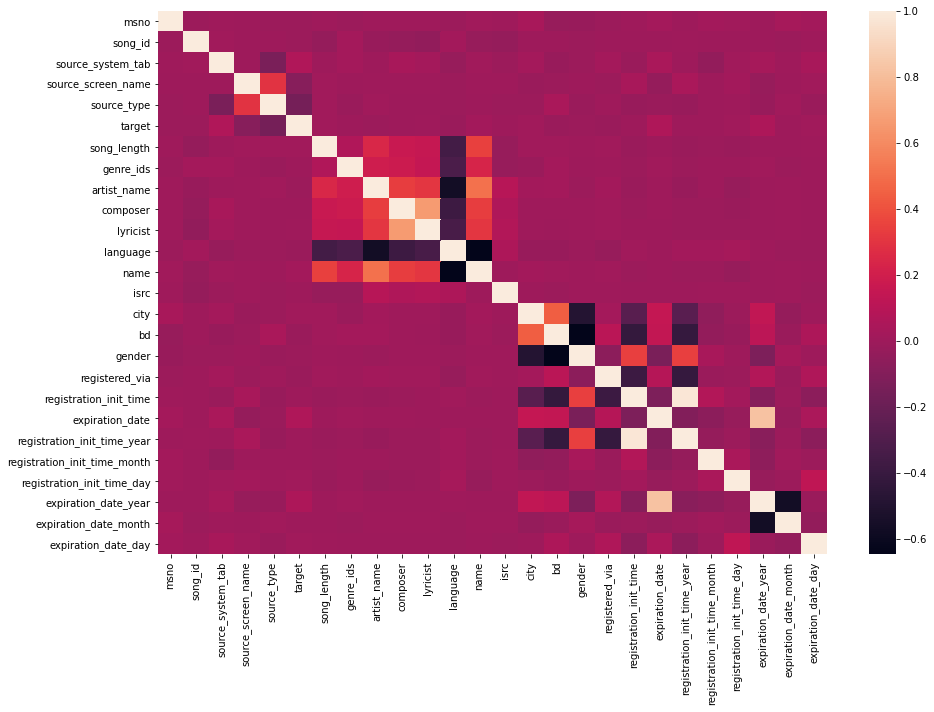

In [10]:
# Сorrelation matrix
plt.figure(figsize=[15,10])
sns.heatmap(songs.corr())
plt.show()

### Modeling 

In [11]:
X = songs.drop('target', axis = 1)
y = songs.target
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [12]:
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=7, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


LR: 0.749653 (0.004535)
LDA: 0.747307 (0.004110)
KNN: 0.717747 (0.004309)
CART: 0.789400 (0.005717)
NB: 0.738720 (0.003106)


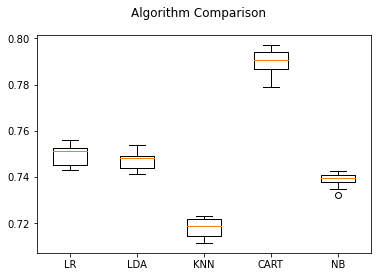

In [13]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Make Predictions

In [14]:
# Make predictions on validation dataset
CART = DecisionTreeClassifier()
CART.fit(X_train, y_train)
predictions = CART.predict(X_val)
print(accuracy_score(y_val, predictions))
print(confusion_matrix(y_val, predictions))
print(classification_report(y_val, predictions))


0.79172
[[ 3655  2521]
 [ 2686 16138]]
              precision    recall  f1-score   support

           0       0.58      0.59      0.58      6176
           1       0.86      0.86      0.86     18824

    accuracy                           0.79     25000
   macro avg       0.72      0.72      0.72     25000
weighted avg       0.79      0.79      0.79     25000



In [15]:
# save the model to disk
CART_recommend = 'finalized_model.sav'
dump(CART, open(CART_recommend, 'wb'))